In [55]:
import pandas as pd
import numpy as np

import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import shapely
import os
import urllib
import requests
import seaborn as sns

from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


# Input Data

In [56]:
sale_train= pd.read_csv('output/data_train.csv')

In [57]:
# link: https://stackoverflow.com/questions/45739890/geopandas-plot-function-not-working
## spatial SALE-PRICE Anomaly detection
import shapely.wkt
sale_train['geometry'] = sale_train['geometry'].apply(shapely.wkt.loads)
sale_train = gpd.GeoDataFrame(sale_train)

In [58]:
features_column = ['YEAR BUILT','RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'easements', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth','assessland', 'assesstot', 'exemptland', 'exempttot', 'builtfar', 'residfar', 'commfar', 'facilfar',
'DensityPop', 
'IncomePerCap', 
'Poverty', 
'Professional', 
'Service', 
'Office', 
'Construction', 
'Production', 
'Employed', 
'Unemployment',
'distance_subway',
'distance_bus',
'park_num',
'park_area',
'park_top_level',
'park_distance',
'FELONY',
'VIOLATION',
'MISDEMEANOR',
'Num of SAT Test Takers', 'satReadingSum', 
'satMathSum',
'satWritingSum']

In [59]:
prices = sale_train['SALE PRICE']
priceData = sale_train[features_column]
numSale = prices.shape[0]
numFeatures = priceData.shape[1]
print("The number of Sales is %d" % numSale)
print("The number of features for each Sales is %d" % numFeatures)
print("The maximum price is ${:,.2f}".format(np.max(prices)))
print("The minimum price is ${:,.2f}".format(np.min(prices)))
print("The median price is ${:,.2f}".format(np.median(prices)))
print("The average price is ${:,.2f}".format(np.mean(prices)))
print("The standard deviation of prices is ${:,.2f}".format(np.std(prices)))

The number of Sales is 8885
The number of features for each Sales is 56
The maximum price is $980,000,000.00
The minimum price is $1.00
The median price is $825,000.00
The average price is $4,023,169.35
The standard deviation of prices is $28,732,320.64


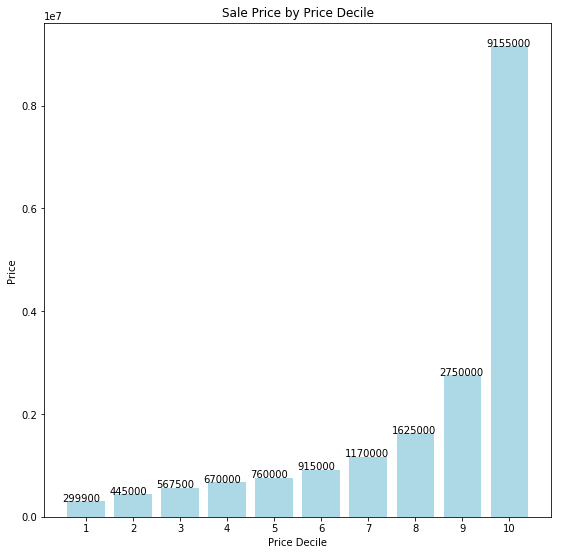

In [60]:
#create deciles dataframes from 

decile_list = []

df = pd.DataFrame(prices)
df['decile'] = pd.qcut(df['SALE PRICE'],10,labels=False)
decile_df = pd.DataFrame(round(df.groupby('decile')['SALE PRICE'].median(),2))
decile_df.reset_index(inplace=True)
decile_list.append(decile_df)

fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.bar(x=decile_df['decile'],height=decile_df['SALE PRICE'],color='lightblue')
ax1.set_xlabel("Price Decile")
ax1.set_ylabel("Price")
ax1.set_title("Sale Price by Price Decile")
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax1.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

for i, v in enumerate(list(decile_df['SALE PRICE'])):
    ax1.text(i - 0.5,v + 0.5, str(v), fontweight='light')

In [61]:
sale_train[['SALE PRICE']+features_column].corr().iloc[:,0].sort_values(ascending = False)[:11]

SALE PRICE           1.000000
GROSS SQUARE FEET    0.797997
LAND SQUARE FEET     0.622765
officearea           0.510890
TOTAL UNITS          0.356051
factryarea           0.326395
COMMERCIAL UNITS     0.284518
RESIDENTIAL UNITS    0.257459
retailarea           0.236498
comarea              0.222199
commfar              0.189151
Name: SALE PRICE, dtype: float64

In [62]:
selected_10_columns = sale_train[['SALE PRICE']+features_column].corr().iloc[:,0].sort_values(ascending = False)[:11].index[1:]
selected_10_columns

Index(['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'officearea', 'TOTAL UNITS',
       'factryarea', 'COMMERCIAL UNITS', 'RESIDENTIAL UNITS', 'retailarea',
       'comarea', 'commfar'],
      dtype='object')

In [63]:
sale_train = sale_train.fillna(0)

In [64]:
def standardize(df):
    return (df-df.mean())/df.std()

def standardize_inverse(df,mean,std):
    return std*df+mean

In [65]:
df = sale_train[['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
X = pd.DataFrame(df.iloc[:,2])

ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                 1.106e+04
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        18:12:36   Log-Likelihood:            -1.0829e+05
No. Observations:                5952   AIC:                         2.166e+05
Df Residuals:                    5951   BIC:                         2.166e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
GROSS SQUARE FEET   680.6962      6.474    105.143      0.000     668.005     693.388
==============================================================================
Omnibus:                    13219.199   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        242477198.163
Skew:                          19.871   Prob(JB):                         0.00
Kurtosis:                     991.004   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:

Y_pred = mod.predict(X_test)
r2_score(Y_test, Y_pred)

0.5835898681831236

----

## Using IQR to filter data

In [67]:
# from tianju
def remove_outlier(df,var):
    # find Q1 and Q3 and IQR
    
    Q1,Q3 = df[var].quantile(0.25),df[var].quantile(0.75)
    IQR = Q3-Q1
    df = df[(df[var]>=(Q1 - 1.5 * IQR))&(df[var]<=(Q3+1.5 * IQR))]
    return df

In [68]:
# print(sale_train.shape)
# sale_train_z = remove_outlier(sale_train, 'SALE PRICE')
# print(sale_train_z.shape)

In [69]:
# list(set(sale_train.index)-set(sale_train_z.index))

In [70]:
# outliner_df = sale_train.iloc[list(set(sale_train.index)-set(sale_train_z.index)),:].sort_values('SALE PRICE').reset_index(drop = True)

In [71]:
# plot_df = pd.DataFrame({'count':outliner_df.groupby('NEIGHBORHOOD').count().iloc[:,0].values,\
# 'neighborhood':outliner_df.groupby('NEIGHBORHOOD').count().iloc[:,0].index})
# plot_df.plot.bar(x='neighborhood',y = 'count',rot = 0)
# plt.xticks(rotation = 90)
# plt.tight_layout()
# print(len(outliner_df))

In [72]:
# outliner_df.landuse.hist()

In [73]:
# sale_train_z.reset_index(drop = True,inplace = True)

In [74]:
# sale_train_z.sort_values('SALE PRICE')

## SALE PRICE Anomaly detection

In [75]:
# remove outliner 

In [76]:
from scipy.stats import zscore

sale_train['SALE_PRICE_log_zscore'] = zscore(np.log10(sale_train['SALE PRICE']))
sale_train['is_outliner_zscore'] = sale_train['SALE_PRICE_log_zscore']\
        .apply(lambda x: x<=-2.5)

# sale_train['SALE_PRICE_log_zscore'] = zscore(np.log10(sale_train['SALE PRICE']))
# sale_train['is_outliner_zscore'] = sale_train['SALE_PRICE_log_zscore']\
#         .apply(lambda x: x<=-2.5 or x>=2.5)

In [77]:
sale_train[sale_train['is_outliner_zscore']].sort_values('SALE PRICE')

,SALE PRICE,SALE DATE,bbl,ct2010,cb2010,borocode,bldgclass,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,...,Num of SAT Test Takers,satReadingSum,satMathSum,satWritingSum,histdist,landmark,landuse,geometry,SALE_PRICE_log_zscore,is_outliner_zscore
6119,1,2018-12-28 00:00:00,1018630010,193.00,5001,1.0,N2,1,UPPER WEST SIDE (96-116),38 ASYLUMS AND HOMES,...,3825,498.0,525.0,496.0,0,0,8.0,"POLYGON ((-73.9638343813151 40.80145062684647,...",-9.652759,True
7126,1,2019-01-17 00:00:00,1021740188,285.00,1001,1.0,C1,1,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,...,4005,441.0,487.0,442.0,0,0,2.0,POLYGON ((-73.92657059905258 40.86165540335139...,-9.652759,True
6773,1,2018-11-08 00:00:00,1015860043,152.00,6006,1.0,D4,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,...,9100,451.0,476.0,447.0,0,0,3.0,POLYGON ((-73.94421251622066 40.77795029819738...,-9.652759,True
8275,1,2018-12-31 00:00:00,1012110007,165.00,5000,1.0,C1,1,UPPER WEST SIDE (79-96),07 RENTALS - WALKUP APARTMENTS,...,3825,498.0,525.0,496.0,Upper West Side / Central Park West Historic D...,0,2.0,POLYGON ((-73.97701037094002 40.78364503209109...,-9.652759,True
4746,1,2018-05-21 00:00:00,1015890041,136.00,5001,1.0,D4,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,...,9100,451.0,476.0,447.0,0,0,3.0,POLYGON ((-73.94626948087021 40.77177082031174...,-9.652759,True
8565,1,2018-05-22 00:00:00,1002290036,47.00,2015,1.0,D4,1,SOHO,10 COOPS - ELEVATOR APARTMENTS,...,9100,451.0,476.0,447.0,SoHo-Cast Iron Historic District,0,3.0,"POLYGON ((-74.0030773002407 40.72116066206237,...",-9.652759,True
3138,1,2018-04-12 00:00:00,1021620051,271.00,2003,1.0,C6,1,WASHINGTON HEIGHTS UPPER,09 COOPS - WALKUP APARTMENTS,...,4005,441.0,487.0,442.0,0,0,2.0,"POLYGON ((-73.9350730561938 40.8493276943878, ...",-9.652759,True
2921,1,2018-06-26 00:00:00,1019530041,215.00,1002,1.0,HR,1,HARLEM-CENTRAL,26 OTHER HOTELS,...,2850,432.0,459.0,427.0,0,0,5.0,"POLYGON ((-73.9510657612599 40.8117282596031, ...",-9.652759,True
2920,1,2018-06-26 00:00:00,1019530041,215.00,1002,1.0,HR,1,HARLEM-CENTRAL,26 OTHER HOTELS,...,2850,432.0,459.0,427.0,0,0,5.0,POLYGON ((-73.95112109316518 40.81175152671895...,-9.652759,True
2749,1,2018-08-15 00:00:00,1012460039,171.00,4000,1.0,D4,1,UPPER WEST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,...,3825,498.0,525.0,496.0,Riverside-West End Historic District Extension I,0,3.0,"POLYGON ((-73.97925547656335 40.7882328082737,...",-9.652759,True


Text(0.5, 1.0, 'Sale Price per Number of sale')

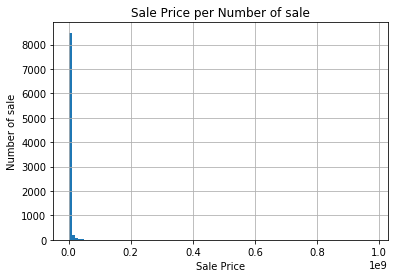

In [78]:
sale_train['SALE PRICE'].hist(bins = 100)

plt.xlabel("Sale Price")
plt.ylabel("Number of sale")
plt.title("Sale Price per Number of sale")

In [79]:
len(sale_train[sale_train['SALE PRICE']<=1*1e4])

61

Text(0.5, 1.0, 'log Sale Price per Number of sale')

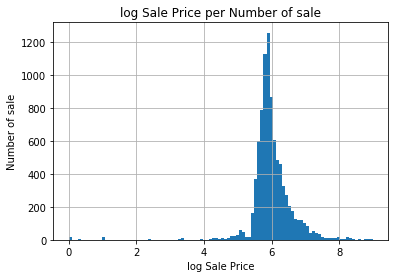

In [80]:
np.log10(sale_train['SALE PRICE']).hist(bins = 100)
plt.xlabel("log Sale Price")
plt.ylabel("Number of sale")
plt.title("log Sale Price per Number of sale")

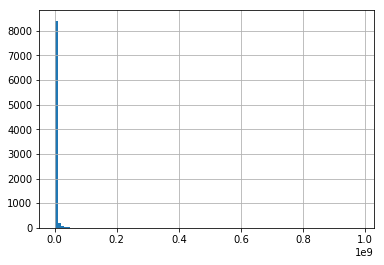

In [81]:
sale_train[~sale_train['is_outliner_zscore']]['SALE PRICE'].hist(bins = 100)

In [82]:
#np.log10(sale_train[~sale_train['is_outliner_zscore']]['SALE PRICE']).hist(bins = 100)

## spatial SALE-PRICE Anomaly detection

In [83]:
#can use Isolation Forest / Incremental Local Evolutional Outlier Detection(IcLEOD)

In [84]:
# from sklearn.cluster import DBSCAN
# import sklearn.cluster as cluster


In [85]:
# fig = plt.figure(figsize = (20,20))
# ax = fig.add_subplot(111)
# sale_train.plot(ax = ax,column = 'SALE PRICE',legend = 'SALE PRICE')

In [86]:
# fig = plt.figure(figsize = (20,20))
# ax = fig.add_subplot(111)
# sale_train[~sale_train['is_outliner_log_zscore']].plot(ax = ax,column = 'SALE PRICE',legend = 'SALE PRICE')

In [87]:
sale_train['Centroid'] = sale_train['geometry'].centroid
sale_train['x'] = sale_train.Centroid.apply(lambda p:p.x)
sale_train['y'] = sale_train.Centroid.apply(lambda p:p.y)

In [88]:
sale_train[~sale_train['is_outliner_zscore']][['SALE PRICE']+features_column].corr().iloc[:,0].sort_values(ascending = False)[:11]

SALE PRICE           1.000000
GROSS SQUARE FEET    0.799309
LAND SQUARE FEET     0.624177
officearea           0.506137
TOTAL UNITS          0.356874
factryarea           0.323555
COMMERCIAL UNITS     0.284524
RESIDENTIAL UNITS    0.258313
retailarea           0.233387
comarea              0.218629
commfar              0.190411
Name: SALE PRICE, dtype: float64

In [89]:
# filter data by zscore <=-.25 and >= .25


In [90]:
len(sale_train)

8885

## Filter data by zscore <=-.25 and >= .25 and built model

In [91]:
sale_train_z = sale_train[sale_train['is_outliner_zscore']==False].reset_index(drop = True)

In [92]:
len(sale_train_z)

8803

In [93]:
# sale_train_z['log_SALE_PRICE'] = np.log10(sale_train_z['SALE PRICE'].astype(float))
# sale_train_z['Normalized_SALE_PRICE'] = sale_train_z['log_SALE_PRICE']- sale_train_z['log_SALE_PRICE'].mean()

In [94]:
sale_train_z.sort_values('SALE PRICE')

,SALE PRICE,SALE DATE,bbl,ct2010,cb2010,borocode,bldgclass,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,...,satWritingSum,histdist,landmark,landuse,geometry,SALE_PRICE_log_zscore,is_outliner_zscore,Centroid,x,y
6587,29000,2018-06-08 00:00:00,1012150035,169.00,3001,1.0,D4,1,UPPER WEST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,...,496.0,Upper West Side / Central Park West Historic D...,0,3.0,POLYGON ((-73.97297640720637 40.78583865695507...,-2.470213,False,POINT (-73.97314979795269 40.7857966776569),-73.973150,40.785797
4893,30420,2019-03-11 00:00:00,1014510023,134.00,5000,1.0,D4,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,...,447.0,0,0,3.0,POLYGON ((-73.95414129182929 40.77089435215739...,-2.436797,False,POINT (-73.95431262204194 40.77073602885424),-73.954313,40.770736
2351,31941,2018-11-16 00:00:00,1004450051,38.00,4000,1.0,C6,1,EAST VILLAGE,09 COOPS - WALKUP APARTMENTS,...,430.0,0,0,2.0,POLYGON ((-73.98840706267143 40.72531449148154...,-2.402691,False,POINT (-73.98851986389801 40.7252340635621),-73.988520,40.725234
1383,33152,2018-07-02 00:00:00,1006320017,75.00,1000,1.0,D4,1,GREENWICH VILLAGE-WEST,10 COOPS - ELEVATOR APARTMENTS,...,447.0,Greenwich Village Historic District Extension,0,3.0,POLYGON ((-74.00748769432919 40.73431405544217...,-2.376678,False,POINT (-74.00734140914575 40.7346235225044),-74.007341,40.734624
7931,34058,2019-02-07 00:00:00,1021150034,241.00,4000,1.0,C7,1,WASHINGTON HEIGHTS LOWER,07 RENTALS - WALKUP APARTMENTS,...,442.0,0,0,4.0,POLYGON ((-73.94228196501642 40.83279358871552...,-2.357831,False,POINT (-73.9424114407347 40.83288803904694),-73.942411,40.832888
6219,35000,2018-08-07 00:00:00,1012030001,173.00,4000,1.0,D4,1,UPPER WEST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,...,496.0,0,0,3.0,POLYGON ((-73.97018807745182 40.78883843695088...,-2.338759,False,POINT (-73.97013123698568 40.78860520929429),-73.970131,40.788605
7493,35054,2018-08-08 00:00:00,1020800025,233.00,2001,1.0,C6,1,HARLEM-UPPER,09 COOPS - WALKUP APARTMENTS,...,442.0,0,0,2.0,POLYGON ((-73.94670225025304 40.82753495657389...,-2.337682,False,POINT (-73.94673425441331 40.82759504214105),-73.946734,40.827595
7492,35054,2018-10-15 00:00:00,1020800025,233.00,2001,1.0,C6,1,HARLEM-UPPER,09 COOPS - WALKUP APARTMENTS,...,442.0,0,0,2.0,POLYGON ((-73.94670225025304 40.82753495657389...,-2.337682,False,POINT (-73.94673425441331 40.82759504214105),-73.946734,40.827595
7494,35054,2018-04-05 00:00:00,1020800025,233.00,2001,1.0,C6,1,HARLEM-UPPER,09 COOPS - WALKUP APARTMENTS,...,442.0,0,0,2.0,POLYGON ((-73.94670225025304 40.82753495657389...,-2.337682,False,POINT (-73.94673425441331 40.82759504214105),-73.946734,40.827595
1084,36751,2018-05-01 00:00:00,1007480001,93.00,1001,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,447.0,0,0,3.0,POLYGON ((-74.00039388750292 40.74714774709433...,-2.304635,False,POINT (-74.00037572988485 40.74733996105027),-74.000376,40.747340


In [95]:
# Bayesian network structure for only the top 10 features

In [96]:
sale_train_z[['SALE PRICE']+features_column].corr().iloc[:,0].sort_values(ascending = False)[:11]

SALE PRICE           1.000000
GROSS SQUARE FEET    0.799309
LAND SQUARE FEET     0.624177
officearea           0.506137
TOTAL UNITS          0.356874
factryarea           0.323555
COMMERCIAL UNITS     0.284524
RESIDENTIAL UNITS    0.258313
retailarea           0.233387
comarea              0.218629
commfar              0.190411
Name: SALE PRICE, dtype: float64

In [97]:
selected_10_columns = sale_train_z[['SALE PRICE']+features_column].corr().iloc[:,0].sort_values(ascending = False)[1:11].index

In [98]:
selected_10_columns

Index(['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'officearea', 'TOTAL UNITS',
       'factryarea', 'COMMERCIAL UNITS', 'RESIDENTIAL UNITS', 'retailarea',
       'comarea', 'commfar'],
      dtype='object')

In [99]:
['SALE PRICE']+['landuse']+selected_10_columns.tolist()

['SALE PRICE',
 'landuse',
 'GROSS SQUARE FEET',
 'LAND SQUARE FEET',
 'officearea',
 'TOTAL UNITS',
 'factryarea',
 'COMMERCIAL UNITS',
 'RESIDENTIAL UNITS',
 'retailarea',
 'comarea',
 'commfar']

## Train & Test split

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [101]:
# return function 

def standardize(df):
    return (df-df.mean())/df.std()
def standardize_inverse(df, mean, std):
    return std * df + mean

### OLS_OriginalData

In [102]:
# sale_train_z = sale_train

In [103]:
df = sale_train_z[['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1176.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        18:12:47   Log-Likelihood:            -1.0712e+05
No. Observations:                5898   AIC:                         2.143e+05
Df Residuals:                    5889   BIC:                         2.143e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
GROSS SQUARE FEET   856.0481     18.005     47.546      0.000     820.752     891.344
LAND SQUARE FEET   -609.9915    125.886     -4.846      0.000    -856.775    -363.208
officearea         -255.2828     20.005    -12.761      0.000    -294.500    -216.065
TOTAL UNITS        2.077e+04   2.14e+04      0.970      0.332   -2.12e+04    6.28e+04
factryarea           19.0897     31.143      0.613      0.540     -41.963      80.142
COMMERCIAL UNITS   4.555e+05   4.04e+04     11.271      0.000    3.76e+05    5.35e+05
RESIDENTIAL UNITS -4.347e+05    2.7e+04    -16.110      0.000   -4.88e+05   -3.82e+05
retailarea          111.8616     13.299      8.411      0.000      85.790     137.933
comarea              -1.1969      3.418     -0.350      0.726      -7.897       5.503
commfar            4.046e+05   8.02e+04      5.046      0.000    2.47e+05    5.62e+05
==============================================================================
Omnibus:                    13627.716   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        290733190.935
Skew:                          21.896   Prob(JB):                         0.00
Kurtosis:                    1089.797   Cond. No.                     2.90e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.33e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [104]:
from sklearn.metrics import r2_score
Y_pred = mod.predict(X_test)
r2_score(Y_test, Y_pred)

0.7838977222152603

### Standardise data

In [105]:
##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_standardized_train, X_standardized_train).fit()
mod.summary()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     1150.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        18:12:47   Log-Likelihood:                -5793.5
No. Observations:                5898   AIC:                         1.161e+04
Df Residuals:                    5889   BIC:                         1.167e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
GROSS SQUARE FEET     1.0155      0.021     47.873      0.000       0.974       1.057
LAND SQUARE FEET     -0.0859      0.016     -5.408      0.000      -0.117      -0.055
officearea           -0.1872      0.014    -12.921      0.000      -0.216      -0.159
TOTAL UNITS          -0.0600      0.007     -9.110      0.000      -0.073      -0.047
factryarea            0.0058      0.009      0.637      0.524      -0.012       0.024
COMMERCIAL UNITS      0.1490      0.013     11.039      0.000       0.123       0.175
RESIDENTIAL UNITS    -0.1495      0.009    -17.473      0.000      -0.166      -0.133
retailarea            0.0718      0.009      7.789      0.000       0.054       0.090
comarea              -0.0193      0.010     -1.983      0.047      -0.038      -0.000
commfar               0.0222      0.009      2.555      0.011       0.005       0.039
==============================================================================
Omnibus:                    13690.669   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        296662565.376
Skew:                          22.149   Prob(JB):                         0.00
Kurtosis:                    1100.820   Cond. No.                     5.19e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.22e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [106]:
from sklearn.metrics import r2_score
Y_pred = mod.predict(X_standardized_test)
r2_score(Y_standardized_test, Y_pred)

0.7842082915476565

# Anomaly Detection( Isolation Forrest and OneClassSVM, Categories + Gaussian)

In [107]:
# reference link:https://www.cnblogs.com/pinard/p/9314198.html

`isolation Forest`:
Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

`One Class SVM`:
Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [108]:
# sale_train['SALE_PRICE_log_zscore'] = zscore(np.log10(sale_train['SALE PRICE']))
# sale_train['is_outliner_zscore'] = sale_train['SALE_PRICE_log_zscore']\
#         .apply(lambda x: x<=-2.5 or x>=2.5)

In [109]:
# sale_train['SALE_PRICE_log_zscore'] = zscore(np.log10(sale_train['SALE PRICE']))
# sale_train['is_outliner_zscore'] = sale_train['SALE_PRICE_log_zscore']\
#         .apply(lambda x: x<=-2.5)

In [110]:
# reset sale_train_z

#sale_train_z = sale_train[sale_train['is_outliner_log_zscore']==False].reset_index(drop = True)

#sale_train_z_3 = sale_train_z[sale_train_z['landuse']==3.0].reset_index(drop = True)
# sale_train_z =  sale_train

In [111]:
# Only landuse = 3.0
#sale_train_z = sale_train_z[sale_train_z['landuse']==3.0].reset_index(drop = True)

In [112]:
#reference link: https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection

In [113]:
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [114]:
outliers_fraction = 0.005

In [115]:
min_max_scaler = preprocessing.StandardScaler()
data = sale_train_z[['SALE PRICE']+features_column]
data = data.fillna(0)
data_scale = min_max_scaler.fit_transform(data)
data_scale = pd.DataFrame(data_scale)

model = IsolationForest(contamination=outliers_fraction)
model.fit(data_scale)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.005,
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

In [ ]:
# a['SALE PRICE'].sort_values()

C:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


38


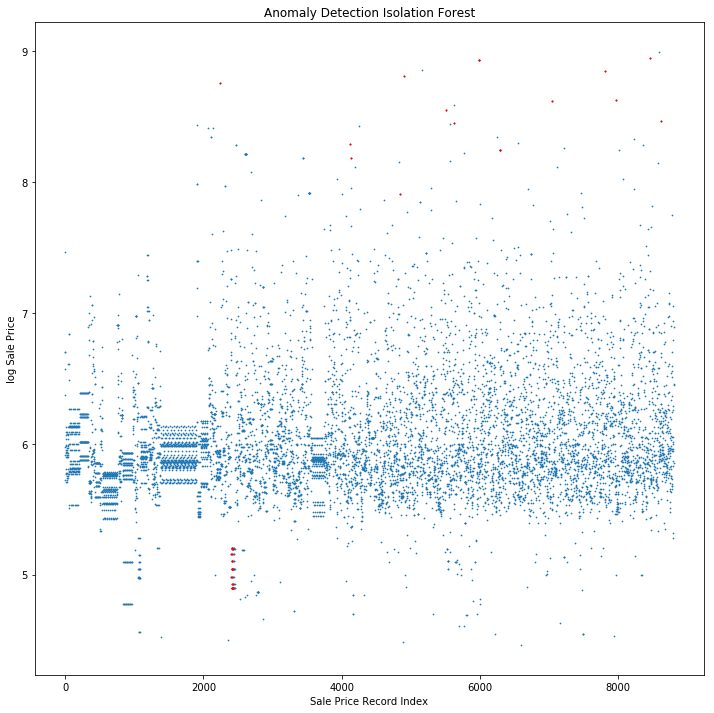

In [117]:
sale_train_z['anomaly_if'] = pd.Series(model.predict(data_scale)).map({1:0,-1:1})
a = sale_train_z.loc[sale_train_z['anomaly_if']!=0,['SALE PRICE']]
# a.sort_values('SALE PRICE')
print(len(a))
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

ax.scatter(data.index,np.log10(data['SALE PRICE']),s = 0.5)
ax.scatter(a.index,np.log10(a['SALE PRICE']),s=1,color = 'red')
plt.title('Anomaly Detection Isolation Forest')
plt.xlabel('Sale Price Record Index')
plt.ylabel('log Sale Price')
plt.show()

In [119]:
sale_train_z.iloc[a.index,:].sort_values('SALE PRICE')

,SALE PRICE,SALE DATE,bbl,ct2010,cb2010,borocode,bldgclass,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,...,histdist,landmark,landuse,geometry,SALE_PRICE_log_zscore,is_outliner_zscore,Centroid,x,y,anomaly_if
2414,79046,2018-06-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.769274,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
2434,79046,2018-06-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99762704102763 40.74879876457375...,-1.769274,False,POINT (-73.9978515735643 40.74868099604416),-73.997852,40.748681,1
2424,79046,2018-06-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99661778238107 40.74850199467004...,-1.769274,False,POINT (-73.99689223337394 40.74819825013429),-73.996892,40.748198,1
2421,79630,2018-08-07 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99661778238107 40.74850199467004...,-1.764129,False,POINT (-73.99689223337394 40.74819825013429),-73.996892,40.748198,1
2431,79630,2018-08-07 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99762704102763 40.74879876457375...,-1.764129,False,POINT (-73.9978515735643 40.74868099604416),-73.997852,40.748681,1
2411,79630,2018-08-07 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.764129,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
2423,84315,2018-06-15 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99661778238107 40.74850199467004...,-1.724166,False,POINT (-73.99689223337394 40.74819825013429),-73.996892,40.748198,1
2413,84315,2018-06-15 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.724166,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
2406,96258,2018-10-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.631564,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
2416,96258,2018-10-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99661778238107 40.74850199467004...,-1.631564,False,POINT (-73.99689223337394 40.74819825013429),-73.996892,40.748198,1


C:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


38


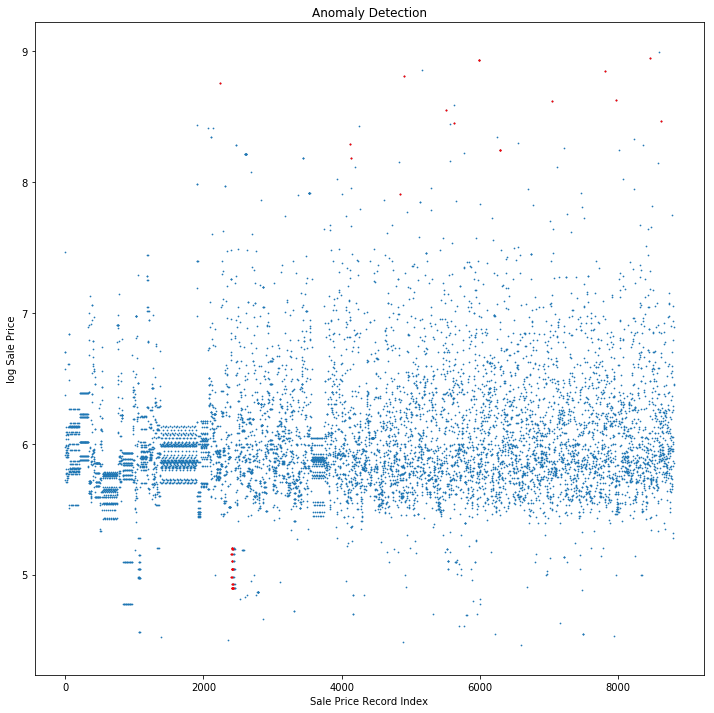

In [120]:
sale_train_z['anomaly_if'] = pd.Series(model.predict(data_scale)).map({1:0,-1:1})
a = sale_train_z.loc[sale_train_z['anomaly_if']!=0,['SALE PRICE']]
# a.sort_values('SALE PRICE')
print(len(a))
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

ax.scatter(data.index,np.log10(data['SALE PRICE']),s = 0.5)
ax.scatter(a.index,np.log10(a['SALE PRICE']),s=1,color = 'red')
plt.title('Anomaly Detection')
plt.xlabel('Sale Price Record Index')
plt.ylabel('log Sale Price')
plt.show()


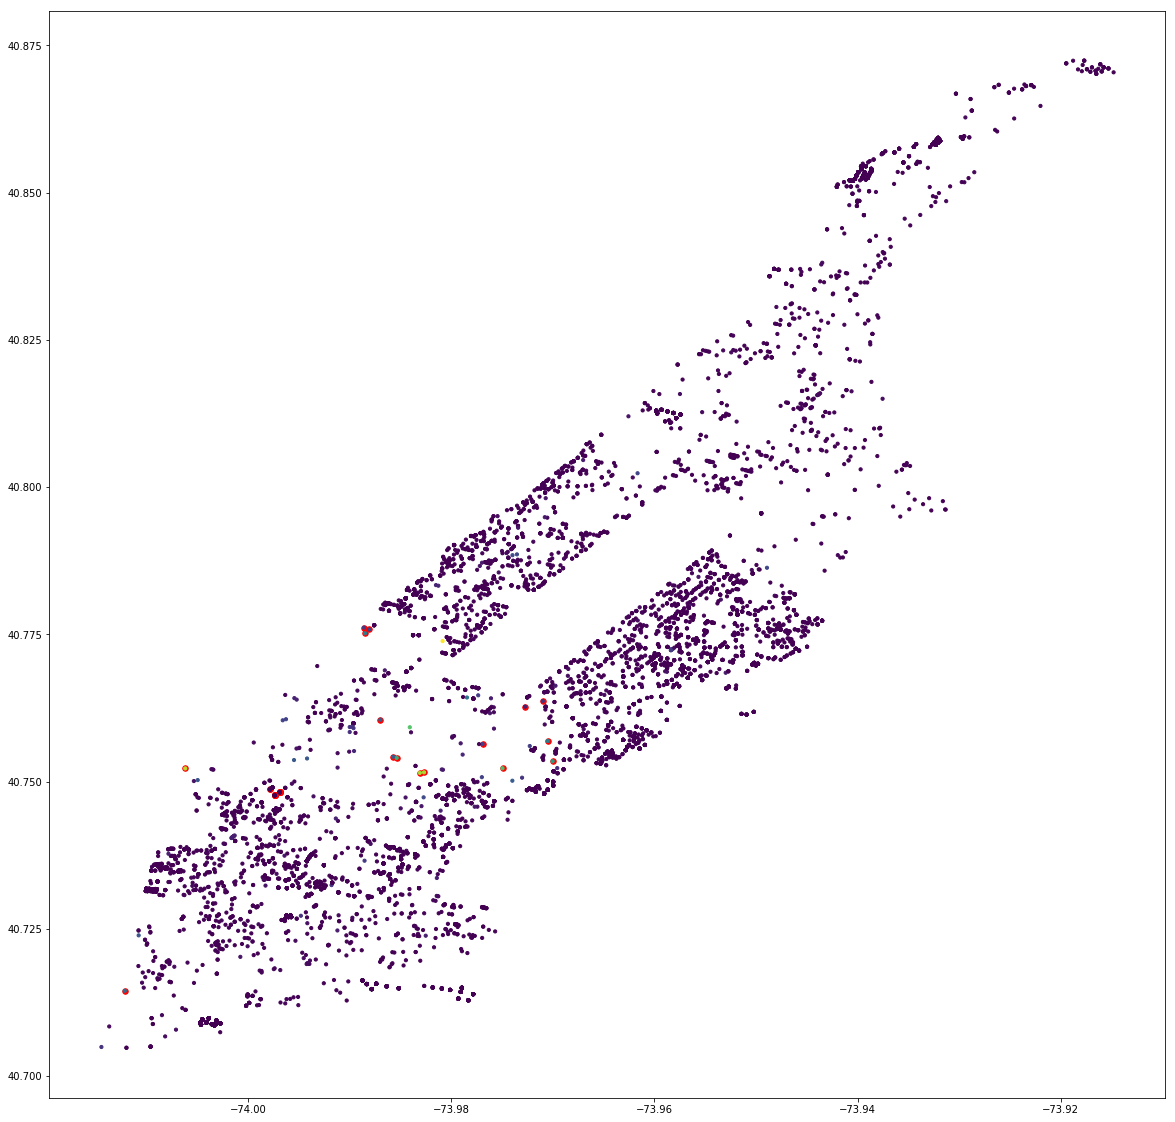

In [121]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.scatter(sale_train_z.iloc[a.index,:]['x'],sale_train_z.iloc[a.index,:]['y'],c ='red',s=30)
ax.scatter(sale_train_z['x'],sale_train_z['y'],c = sale_train_z['SALE PRICE'],s=10)


In [122]:
# redo ols model

In [123]:
a_df = sale_train_z.iloc[a.index,:].reset_index(drop = True)
a_df

,SALE PRICE,SALE DATE,bbl,ct2010,cb2010,borocode,bldgclass,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,...,histdist,landmark,landuse,geometry,SALE_PRICE_log_zscore,is_outliner_zscore,Centroid,x,y,anomaly_if
0,565754371,2019-01-08 00:00:00,1013210022,90.00,5001,1.0,O4,1,MIDTOWN EAST,21 OFFICE BUILDINGS,...,0,0,5.0,POLYGON ((-73.96999966567495 40.75318882493833...,4.435216,False,POINT (-73.97003183591576 40.75346363719637),-73.970032,40.753464,1
1,96258,2018-10-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.631564,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
2,143861,2018-09-26 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.350684,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
3,159260,2018-08-23 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.279600,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
4,127408,2018-08-20 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.435583,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
5,111482,2018-08-09 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.528925,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
6,79630,2018-08-07 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.764129,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
7,111073,2018-07-26 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.531495,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
8,84315,2018-06-15 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.724166,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1
9,79046,2018-06-01 00:00:00,1007510001,97.00,1002,1.0,D4,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,...,0,0,3.0,POLYGON ((-73.99718530485487 40.74736022206167...,-1.769274,False,POINT (-73.99738952755698 40.74766624544146),-73.997390,40.747666,1


In [124]:
type(a_df.groupby('NEIGHBORHOOD').count().iloc[:,0].values)

numpy.ndarray

38


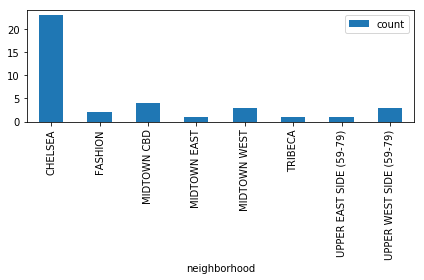

In [125]:
plot_df = pd.DataFrame({'count':a_df.groupby('NEIGHBORHOOD').count().iloc[:,0].values,\
'neighborhood':a_df.groupby('NEIGHBORHOOD').count().iloc[:,0].index})
plot_df.plot.bar(x='neighborhood',y = 'count',rot = 0)
plt.xticks(rotation = 90)
plt.tight_layout()
print(len(a_df))

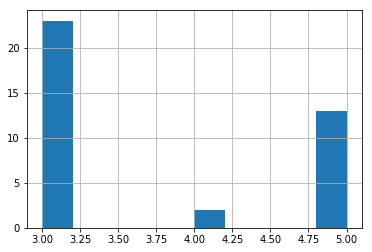

In [126]:
sale_train_z[sale_train_z.anomaly_if!=0].reset_index().landuse.hist()

In [127]:
df = sale_train_z[sale_train_z['anomaly_if']==0][['SALE PRICE']+['landuse']+selected_10_columns.tolist()]

In [128]:
len(df)

8765

In [129]:
#df = sale_train_z[['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
#df = sale_train[['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
#df = sale_train_z_3[['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
#df = sale_train_z[sale_train_z['landuse']==3.0][['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
#
#df = sale_train_z[['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardS

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     495.4
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        18:17:01   Log-Likelihood:            -1.0582e+05
No. Observations:                5872   AIC:                         2.117e+05
Df Residuals:                    5863   BIC:                         2.117e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
GROSS SQUARE FEET   659.4273     16.849     39.137      0.000     626.397     692.458
LAND SQUARE FEET    563.5800    132.027      4.269      0.000     304.758     822.402
officearea           34.4173     26.026      1.322      0.186     -16.604      85.438
TOTAL UNITS       -5.506e+04   2.53e+04     -2.175      0.030   -1.05e+05   -5429.879
factryarea          822.8024   1116.160      0.737      0.461   -1365.282    3010.887
COMMERCIAL UNITS   2.409e+05   4.55e+04      5.295      0.000    1.52e+05     3.3e+05
RESIDENTIAL UNITS -2.959e+05   2.67e+04    -11.093      0.000   -3.48e+05   -2.44e+05
retailarea           21.3564     12.341      1.731      0.084      -2.836      45.549
comarea               2.6539      3.002      0.884      0.377      -3.231       8.538
commfar             3.55e+05    7.1e+04      5.000      0.000    2.16e+05    4.94e+05
==============================================================================
Omnibus:                    15885.714   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        731295695.626
Skew:                          32.741   Prob(JB):                         0.00
Kurtosis:                    1730.617   Cond. No.                     4.66e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.71e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [130]:
from sklearn.metrics import r2_score
Y_pred = mod.predict(X_test)
r2_score(Y_test, Y_pred)

0.2084753067845585

In [131]:
sale_train_z[sale_train_z['anomaly_if']==0].reset_index(drop = True).to_csv('output/IsoForestData_z.csv',index = False)

In [132]:
# The anomaly detection return mostly Multifamily elevator family

In [133]:
## Random Forest Regression

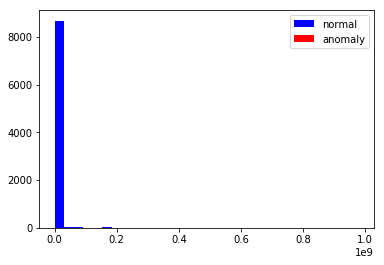

In [134]:
# visualisation of anomaly with temperature repartition (viz 2)
a = sale_train_z.loc[sale_train_z['anomaly_if'] == 0, 'SALE PRICE']
b = sale_train_z.loc[sale_train_z['anomaly_if'] == 1, 'SALE PRICE']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
#axs.hist([a], bins=32, stacked=True, color=['red'], label = ['anomaly'])
plt.legend()
plt.show()

In [135]:
# one class SVM
from sklearn.svm import OneClassSVM

In [136]:

min_max_scaler = preprocessing.StandardScaler()
data = sale_train_z[['SALE PRICE']+features_column]
data = data.fillna(0)
data_scale = min_max_scaler.fit_transform(data)
data_scale = pd.DataFrame(data_scale)
outliers_fraction = 0.005
#SVM
model = OneClassSVM(nu=0.95*outliers_fraction)
model.fit(data_scale)
sale_train_z['anomaly_oneClassSVM'] = pd.Series(model.predict(data_scale)).map({1:0,-1:1})

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


179


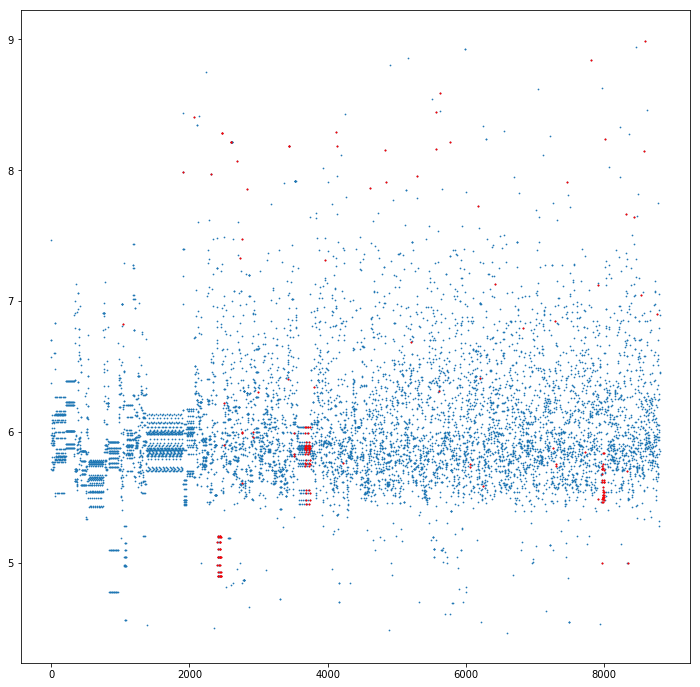

In [137]:
sale_train_z['anomaly_if'] = pd.Series(model.predict(data_scale)).map({1:0,-1:1})
a = sale_train_z.loc[sale_train_z['anomaly_if']!=0,['SALE PRICE']]
# a.sort_values('SALE PRICE')
print(len(a))
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

ax.scatter(data.index,np.log10(data['SALE PRICE']),s = 0.5)
ax.scatter(a.index,np.log10(a['SALE PRICE']),s=1,color = 'red')

plt.show()

179


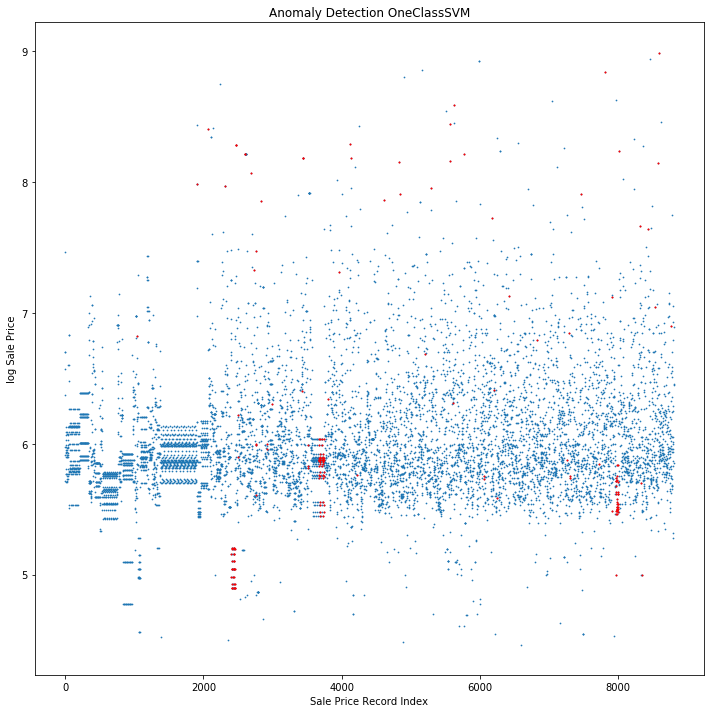

In [140]:
sale_train_z['anomaly_oneClassSVM'] = pd.Series(model.predict(data_scale)).map({1:0,-1:1})
a = sale_train_z.loc[sale_train_z['anomaly_oneClassSVM']!=0,['SALE PRICE']]
# a.sort_values('SALE PRICE')
print(len(a))
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

ax.scatter(data.index,np.log10(data['SALE PRICE']),s = 0.5)
ax.scatter(a.index,np.log10(a['SALE PRICE']),s=1,color = 'red')
plt.title('Anomaly Detection OneClassSVM')
plt.xlabel('Sale Price Record Index')
plt.ylabel('log Sale Price')
plt.show()

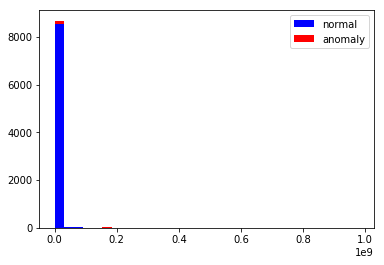

In [141]:
# visualisation of anomaly with temperature repartition (viz 2)
a = sale_train_z.loc[sale_train_z['anomaly_oneClassSVM'] == 0, 'SALE PRICE']
b = sale_train_z.loc[sale_train_z['anomaly_oneClassSVM'] == 1, 'SALE PRICE']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
#axs.hist([a], bins=32, stacked=True, color=['red'], label = ['anomaly'])
plt.legend()
plt.show()

In [142]:
#sale_train_z[sale_train_z['anomaly_oneClassSVM']==0][['SALE PRICE']+['landuse']+selected_10_columns.tolist()].sort_values('SALE PRICE')

In [143]:
df = sale_train_z[sale_train_z['anomaly_oneClassSVM']==0][['SALE PRICE']+['landuse']+selected_10_columns.tolist()]
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()
df = df.fillna(0)

# df = df[df['landuse']==1.0]

Y = df[['SALE PRICE']]
X = df.iloc[:,2:]
ss = StandardScaler()

##
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)
X_standardized = X.apply(standardize)
Y_standardized = Y.apply(standardize)

##Train-Test-Split

X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_standardized_train, X_standardized_test, Y_standardized_train, Y_standardized_test = \
train_test_split(X_standardized, Y_standardized, test_size=0.33, random_state=42)


# Linear Regresssion

mod = sm.OLS(Y_train, X_train).fit()
mod.summary()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardS

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1987.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        18:17:21   Log-Likelihood:            -1.0203e+05
No. Observations:                5778   AIC:                         2.041e+05
Df Residuals:                    5769   BIC:                         2.041e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
GROSS SQUARE FEET   754.3239     14.198     53.130      0.000     726.491     782.157
LAND SQUARE FEET   -570.1575     85.938     -6.635      0.000    -738.629    -401.686
officearea         -235.9035     14.785    -15.956      0.000    -264.887    -206.920
TOTAL UNITS       -6981.9912   9868.847     -0.707      0.479   -2.63e+04    1.24e+04
factryarea          160.2987     21.463      7.469      0.000     118.224     202.374
COMMERCIAL UNITS   2.816e+05   1.36e+04     20.697      0.000    2.55e+05    3.08e+05
RESIDENTIAL UNITS -2.885e+05   1.39e+04    -20.709      0.000   -3.16e+05   -2.61e+05
retailarea          143.2220      8.934     16.031      0.000     125.708     160.736
comarea               0.2138      2.111      0.101      0.919      -3.924       4.352
commfar            2.026e+05   4.99e+04      4.057      0.000    1.05e+05    3.01e+05
==============================================================================
Omnibus:                     4596.498   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10797681.697
Skew:                           2.304   Prob(JB):                         0.00
Kurtosis:                     214.728   Cond. No.                     1.62e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.49e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [144]:

Y_pred = mod.predict(X_test)
r2_score(Y_test, Y_pred)

0.7567384814939391

In [ ]:
#sale_train_z[sale_train_z['anomaly_oneClassSVM']==0].reset_index(drop = True).to_csv('output/OneClassSVMData_z.csv',index = False)

# Using GaussianProcessRegressor 

In [145]:
# https://stackoverflow.com/questions/40576797/numpy-log10-function-attributeerror-float-object-has-no-attribute-log10
sale_train_z['log_SALE_PRICE'] = np.log10(sale_train_z['SALE PRICE'].astype(float))
sale_train_z['Normalized_SALE_PRICE'] = sale_train_z['log_SALE_PRICE']- sale_train_z['log_SALE_PRICE'].mean()

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [147]:
x_obs = sale_train_z[['x','y']]
y_obs = sale_train_z['Normalized_SALE_PRICE']
X_train, X_test, y_train, y_test = train_test_split(x_obs,y_obs, test_size = 0.33, random_state = 234)

In [148]:
# kernel with optimized parameters 

kernel = 1.*RBF(length_scale = 1., length_scale_bounds = (1e-3,1e3))\
        +WhiteKernel(noise_level = 0.1, noise_level_bounds=(1e-10,1e10))

gp = GaussianProcessRegressor(kernel = kernel,random_state=234)
gp.fit(X_train,y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=234)

In [149]:
print(gp.log_marginal_likelihood_value_)
print(gp.kernel_)

-2582.289849539492
0.808**2 * RBF(length_scale=0.001) + WhiteKernel(noise_level=0.0723)


In [150]:
from shapely.ops import unary_union
boundary = gpd.GeoSeries(unary_union(sale_train['Centroid']))
boundary.total_bounds

array([-74.01444935,  40.70481234, -73.91480155,  40.87242575])

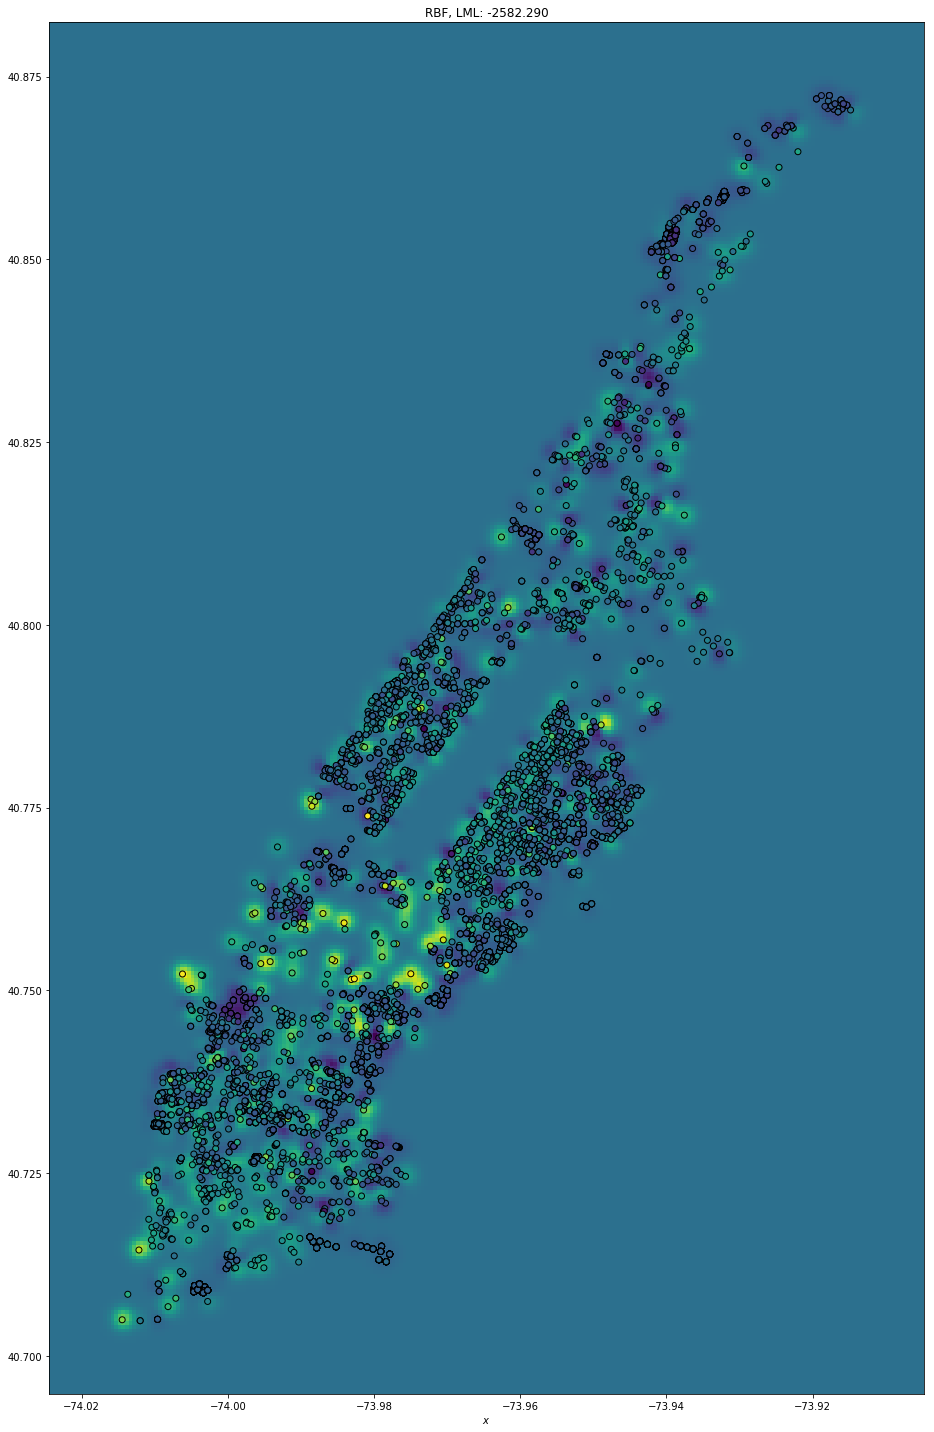

In [151]:
# create a mesh to plot in 
edge = 0.05

# add the x and y in plt.imshow
x_min, x_max = sale_train_z['x'].min()-edge, sale_train_z['x'].max()+edge
y_min, y_max = sale_train_z['y'].min()-edge, sale_train_z['y'].max()+edge

h = 0.0005 # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min,x_max,h),
                                     np.arange(y_min,y_max,h))

plt.figure(figsize = (20, 20))

plt.subplot(1,1,1)

Z = gp.predict(np.c_[xx.ravel(),yy.ravel()])

# put the result into a color plot

Z = Z.reshape((xx.shape[0],xx.shape[1]))

plt.imshow(Z, extent = (x_min, x_max, y_min, y_max), origin = 'lower', cmap = 'viridis')

# plot also the training points
plt.scatter(sale_train_z['x'],sale_train_z['y'], c= sale_train_z['Normalized_SALE_PRICE'],edgecolor = 'black')
plt.xlabel('$x$')
plt.xlabel('$x$')
plt.xlim(boundary.total_bounds[0]-0.01,boundary.total_bounds[2]+0.01)
plt.ylim(boundary.total_bounds[1]-0.01,boundary.total_bounds[3]+0.01)
plt.title("%s, LML: %.3f"%("RBF", gp.log_marginal_likelihood_value_))
plt.tight_layout()

In [152]:
from sklearn.metrics import r2_score
def reNorm(x):
    x = x+sale_train_z['log_SALE_PRICE'].mean()
    y = np.power(10,x)
    return y

y_predict_price_out = reNorm(gp.predict(X_test))
y_predict_price_in = reNorm(gp.predict(X_train))
y_true_price_out= sale_train_z['SALE PRICE'][X_test.index].values
y_true_price_in= sale_train_z['SALE PRICE'][X_train.index].values

print('Out Sample R-squared is {}'.format(r2_score(y_true_price_out,y_predict_price_out)))
print('In Sample R-squared is {}'.format(r2_score(y_true_price_in,y_predict_price_in)))

Out Sample R-squared is 0.0769478654724961
In Sample R-squared is 0.7726142014040147
